In [1]:
import logging
import numpy as np
import amici.plotting

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

# log diagnostics
logger = logging.getLogger("pypesto.petab")
# logger = logging.getLogger('pypesto.')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())
%load_ext autoreload
%autoreload 2

### Generate Synthetic Data

In [2]:
from src.utils import petab as pet
from petab.v1.C import LOG10, LIN

observables_df = pet.define_observables(
    {
        "xA": "xA",
        "xB": "xB",
    },
    noise_value=0.02,
)


params = [
    pet.PetabParameter(id="rA", scale=LOG10, bounds=(1e-2, 1e2), nominal_value=1.0, estimate=True),
    pet.PetabParameter(id="rB", scale=LOG10, bounds=(1e-2, 1e2), nominal_value=1.0, estimate=True),
    pet.PetabParameter(id="rX", scale=LOG10, bounds=(1e-3, 1e3), nominal_value=1.0, estimate=False),
    pet.PetabParameter(id="KAA", scale=LIN, bounds=(0, 1), nominal_value=0.0, estimate=False),
    pet.PetabParameter(id="KAB", scale=LIN, bounds=(0, 1), nominal_value=0.0, estimate=False),
    pet.PetabParameter(id="KBA", scale=LIN, bounds=(0, 1), nominal_value=0.0, estimate=False),
    pet.PetabParameter(id="KBB", scale=LIN, bounds=(0, 1), nominal_value=0.0, estimate=False),
    pet.PetabParameter(id="kpAA", scale=LOG10, bounds=(1e0, 1e6), nominal_value=1.0, estimate=False),
]
parameters_df = pet.define_parameters(params)

The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


### Compile AMICI Model

In [3]:
import src.utils.sbml as sbml
import src.utils.amici as am
from src.models.sbml_models import CRP2_CPE

# Write model to file
sbml_model_filepath = sbml.write_model(CRP2_CPE)

validator = sbml.validateSBML(ucheck=False)
validator.validate(sbml_model_filepath)
model = am.load_amici_model(
    sbml_model_filepath, observables_df=observables_df, force_compile=True
)

Creating SBML model (CRP2_CPE).
Creating CRP parameters.
                 filename : /PolyPESTO/src/models/CRP2_CPE/sbml_model.xml
         file size (byte) : 14278
           read time (ms) : 2.506971
        c-check time (ms) : 1.052141
      validation error(s) : 0
    (consistency error(s)): 0
    validation warning(s) : 0
  (consistency warning(s)): 0
Cleaning existing directory: /PolyPESTO/amici_models/CRP2_CPE
Compiling AMICI model from SBML.


In [31]:
fA = np.array([0.25, 0.5, 0.75], dtype=float)
cM = np.array([1.0, 1.0, 1.0], dtype=float)
R0 = np.array([0.01, 0.01, 0.01], dtype=float)
A0 = fA * cM
B0 = (1 - fA) * cM

# Define conditions dataframe
conditions_df = pet.define_conditions(
    init_conditions={
        "A0": list(A0),
        "B0": list(B0),
    }
)

true_params = {
    "rA": 2.0,
    "rB": 0.5,
    "rX": 1.0,
    "KAA": 0.0,
    "KAB": 0.0,
    "KBA": 0.0,
    "KBB": 0.0,
}
model = am.set_model_parameters(model, true_params)

timepoints = list(np.arange(0, 1, 0.1, dtype=float))
measurements_df, rdatas = pet.define_measurements_amici(
    amici_model=model,
    timepoints=timepoints,
    conditions_df=conditions_df,
    observables_df=observables_df,
    obs_sigma=0.0,
    meas_sigma=0.005,
    debug_return_rdatas=True,
)

yaml_filepath = pet.write_petab_files(
    sbml_model_filepath,
    parameters_df,
    observables_df,
    conditions_df,
    measurements_df,
)
yaml_filepath

Visualization table not available. Skipping.


'/PolyPESTO/src/models/CRP2_CPE/petab.yaml'

### Import Petab Problem

In [32]:
importer = pypesto.petab.PetabImporter.from_yaml(
    yaml_filepath,
    output_folder='/PolyPESTO/amici_models/CRP2_CPE_PETAB/',
    model_name="CRP2_CPE",
)

Visualization table not available. Skipping.


In [33]:
problem = importer.create_problem(force_compile=False)

Using existing amici model in folder /PolyPESTO/amici_models/CRP2_CPE_PETAB/.


In [34]:
# problem.objective.amici_model.requireSensitivitiesForAllParameters()
# problem.objective.edatas[0].
# problem.objective.amici_solver.setAbsoluteTolerance(1e-8)
# problem.objective.amici_solver.setRelativeTolerance(1e-5)

In [35]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(),
    n_chains=3,
)

n_samples = 10000
result = sample.sample(
    problem,
    n_samples=n_samples,
    sampler=sampler,
    x0=np.array([0, 0]),
    # x0=np.array([
    # ]),
    filename=None,
)
elapsed_time = result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")


Initializing betas with "near-exponential decay".
Unknown simulation status: -14
2025-01-11 10:27:34.136 - amici.swig_wrappers - DEBUG - [c_0][idas_ic:IDAICFailFlag:-14] The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.
2025-01-11 10:27:34.136 - amici.swig_wrappers - ERROR - [c_0][OTHER] AMICI simulation failed: IDA routine IDACalcIC failed with error code -14. 
Unknown simulation status: -14
2025-01-11 10:27:34.142 - amici.swig_wrappers - DEBUG - [c_0][idas_ic:IDAICFailFlag:-14] The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.
2025-01-11 10:27:34.143 - amici.swig_wrappers - ERROR - [c_0][OTHER] AMICI simulation failed: IDA routine IDACalcIC failed with error code -14. 
Unknown simulation status: -14
2025-01-11 10:27:34.148 - amici.swig_wrappers - DEBUG - [c_0][idas_ic:IDAICFailFlag:-14] The residual routine or the linear setup or solve routine ha

Elapsed time: 29.0


/usr/local/lib/python3.10/dist-packages/pypesto/visualize/sampling.py:1117: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  nr_params, params_fval, theta_lb, theta_ub, param_names = get_data_to_plot(


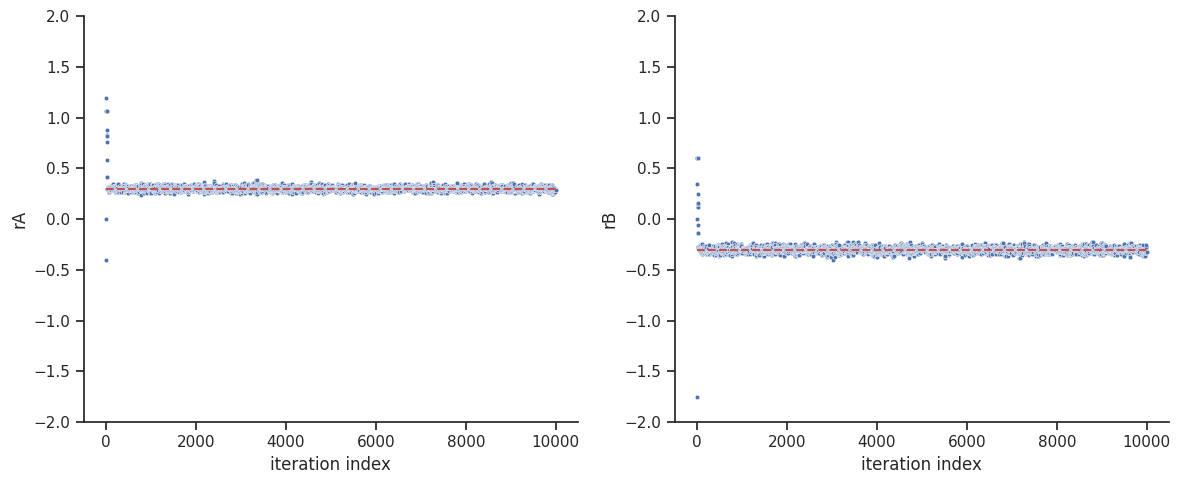

In [36]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=True, size=(12, 5)
)
ax[0][0].plot([0, n_samples], np.log10([true_params["rA"], true_params["rA"]]), "r--")
ax[0][1].plot([0, n_samples], np.log10([true_params["rB"], true_params["rB"]]), "r--")